In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, roc_curve, precision_recall_curve,
                            accuracy_score, precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
import pickle
import os
import warnings

warnings.filterwarnings('ignore')

print("Model Training Pipeline Starting...")
print("="*80)

Model Training Pipeline Starting...


In [2]:
# 1. LOAD PROCESSED DATA

print("\nLOADING DATA")
print("="*80)

X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"\nClass distribution:")
print(f"  No Churn: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  Churn: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")



LOADING DATA
Training set: (5634, 39)
Testing set: (1409, 39)

Class distribution:
  No Churn: 4139 (73.5%)
  Churn: 1495 (26.5%)


In [3]:
# 2. HANDLE CLASS IMBALANCE WITH SMOTE

print("\nHANDLING CLASS IMBALANCE")
print("="*80)

print("Before SMOTE:")
print(f"  Class 0: {(y_train == 0).sum()}")
print(f"  Class 1: {(y_train == 1).sum()}")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(f"  Class 0: {(y_train_balanced == 0).sum()}")
print(f"  Class 1: {(y_train_balanced == 1).sum()}")
print(f"Dataset balanced using SMOTE")
 


HANDLING CLASS IMBALANCE
Before SMOTE:
  Class 0: 4139
  Class 1: 1495

After SMOTE:
  Class 0: 4139
  Class 1: 4139
Dataset balanced using SMOTE


In [4]:
# 3. MODEL TRAINING

print("\nTRAINING MODELS")
print("="*80)

# Dictionary to store models and results
models = {}
results = {}

# 1. Logistic Regression
print("\n1.Training Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_balanced, y_train_balanced)
models['Logistic Regression'] = lr
print("   ✓ Complete")

# 2. Decision Tree
print("2.Training Decision Tree...")
dt = DecisionTreeClassifier(random_state=42, max_depth=10)
dt.fit(X_train_balanced, y_train_balanced)
models['Decision Tree'] = dt
print("   ✓ Complete")

# 3. Random Forest
print("3.Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_balanced, y_train_balanced)
models['Random Forest'] = rf
print("   ✓ Complete")

# 4. Gradient Boosting
print("4.Training Gradient Boosting...")
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_balanced, y_train_balanced)
models['Gradient Boosting'] = gb
print("   ✓ Complete")

# 5. XGBoost
print("5.Training XGBoost...")
xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb.fit(X_train_balanced, y_train_balanced)
models['XGBoost'] = xgb
print("   ✓ Complete")

# 6. LightGBM
print("6.Training LightGBM...")
lgbm = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
lgbm.fit(X_train_balanced, y_train_balanced)
models['LightGBM'] = lgbm
print("   ✓ Complete")

print(f"\nAll {len(models)} models trained successfully!")
print(models.items())


TRAINING MODELS

1.Training Logistic Regression...
   ✓ Complete
2.Training Decision Tree...
   ✓ Complete
3.Training Random Forest...
   ✓ Complete
4.Training Gradient Boosting...
   ✓ Complete
5.Training XGBoost...
   ✓ Complete
6.Training LightGBM...
   ✓ Complete

All 6 models trained successfully!
dict_items([('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)), ('Decision Tree', DecisionTreeClassifier(max_depth=10, random_state=42)), ('Random Forest', RandomForestClassifier(n_jobs=-1, random_state=42)), ('Gradient Boosting', GradientBoostingClassifier(random_state=42)), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=No

In [5]:
# 4. MODEL EVALUATION

print("\nEVALUATING MODELS")
print("="*80)

# Evaluate each model
for name, model in models.items():
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")



EVALUATING MODELS

Logistic Regression:
  Accuracy:  0.7452
  Precision: 0.5130
  Recall:    0.7941
  F1-Score:  0.6233
  ROC-AUC:   0.8441

Decision Tree:
  Accuracy:  0.7339
  Precision: 0.4990
  Recall:    0.6364
  F1-Score:  0.5593
  ROC-AUC:   0.7342

Random Forest:
  Accuracy:  0.7757
  Precision: 0.5771
  Recall:    0.5802
  F1-Score:  0.5787
  ROC-AUC:   0.8241

Gradient Boosting:
  Accuracy:  0.7835
  Precision: 0.5804
  Recall:    0.6658
  F1-Score:  0.6202
  ROC-AUC:   0.8436

XGBoost:
  Accuracy:  0.7779
  Precision: 0.5850
  Recall:    0.5615
  F1-Score:  0.5730
  ROC-AUC:   0.8215

LightGBM:
  Accuracy:  0.7814
  Precision: 0.5892
  Recall:    0.5829
  F1-Score:  0.5860
  ROC-AUC:   0.8340


In [6]:
# 5. MODEL COMPARISON

print("\nMODEL COMPARISON")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
comparison_df = comparison_df.round(2)

print(comparison_df)

# Find best model
best_model_name = comparison_df['ROC-AUC'].idxmax()
best_model = models[best_model_name]

print(f"\nBest Model: {best_model_name} (ROC-AUC: {comparison_df.loc[best_model_name, 'ROC-AUC']:.4f})")



MODEL COMPARISON
                     Accuracy Precision    Recall  F1-Score   ROC-AUC
Logistic Regression  0.745209  0.512953  0.794118  0.623295  0.844137
Decision Tree        0.733854  0.498952  0.636364  0.559342  0.734227
Random Forest        0.775727  0.577128  0.580214  0.578667  0.824144
Gradient Boosting    0.783534   0.58042  0.665775  0.620174  0.843611
XGBoost              0.777857  0.584958  0.561497  0.572988  0.821465
LightGBM             0.781405  0.589189  0.582888  0.586022  0.833993

Best Model: Logistic Regression (ROC-AUC: 0.8441)



CREATING VISUALIZATIONS


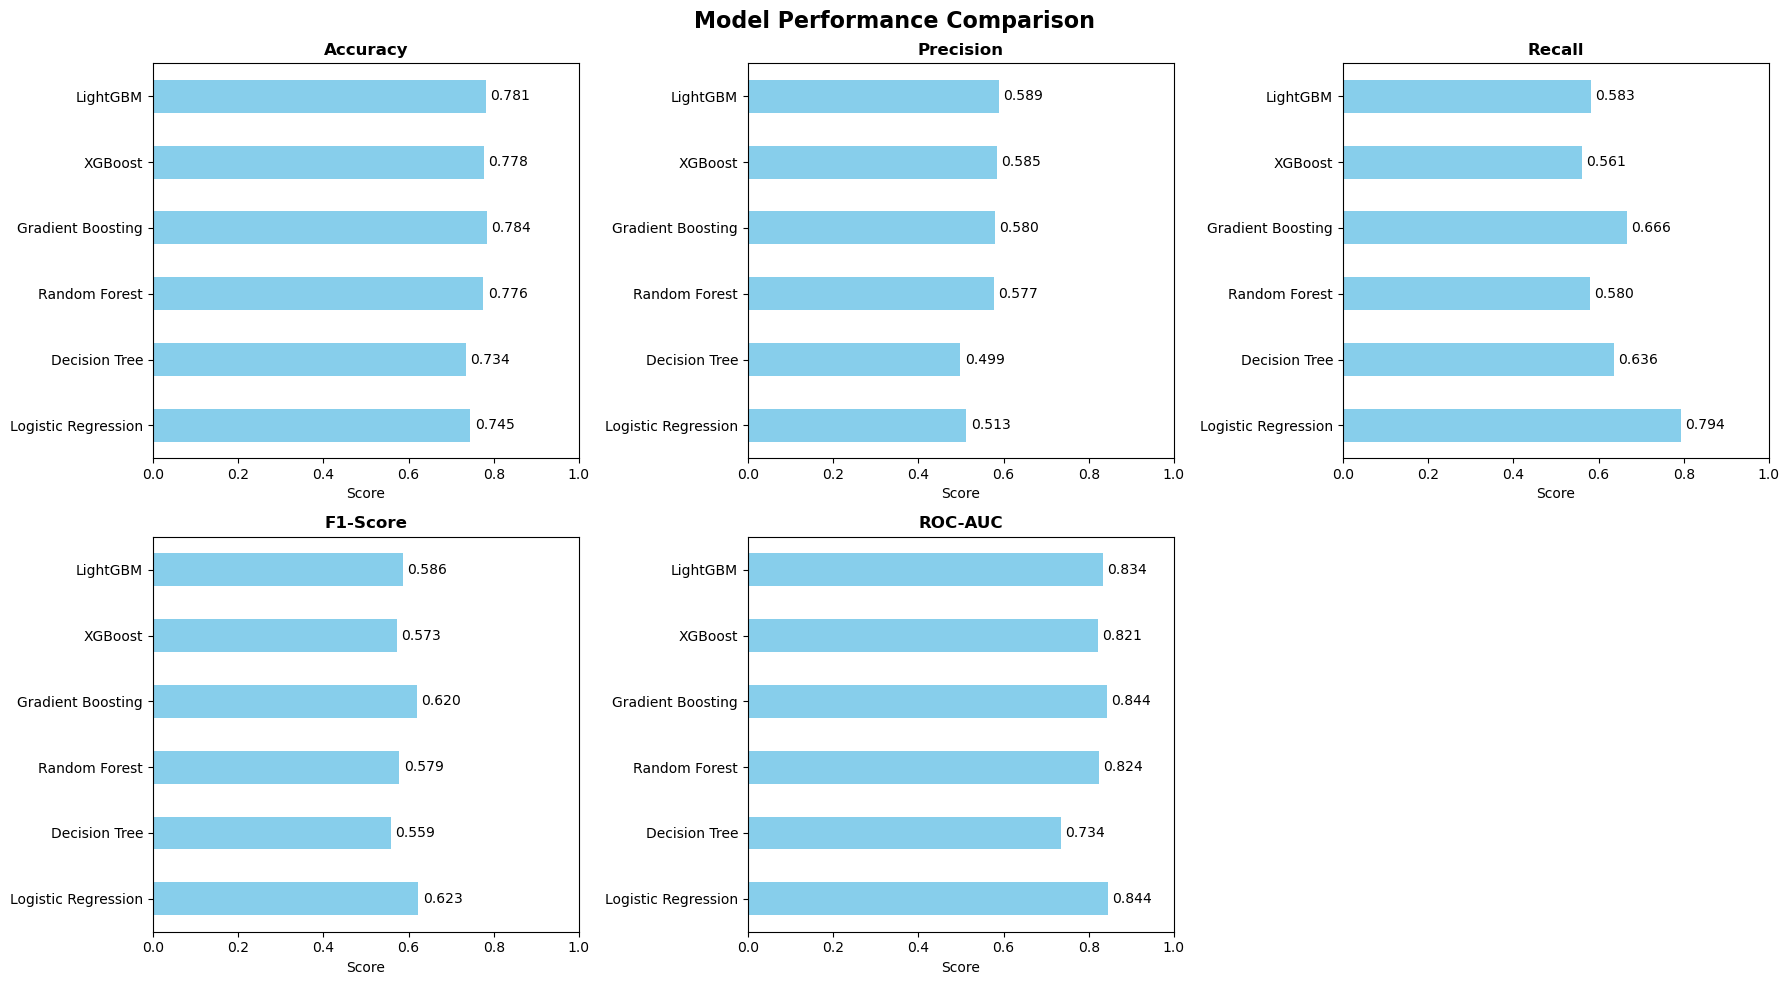

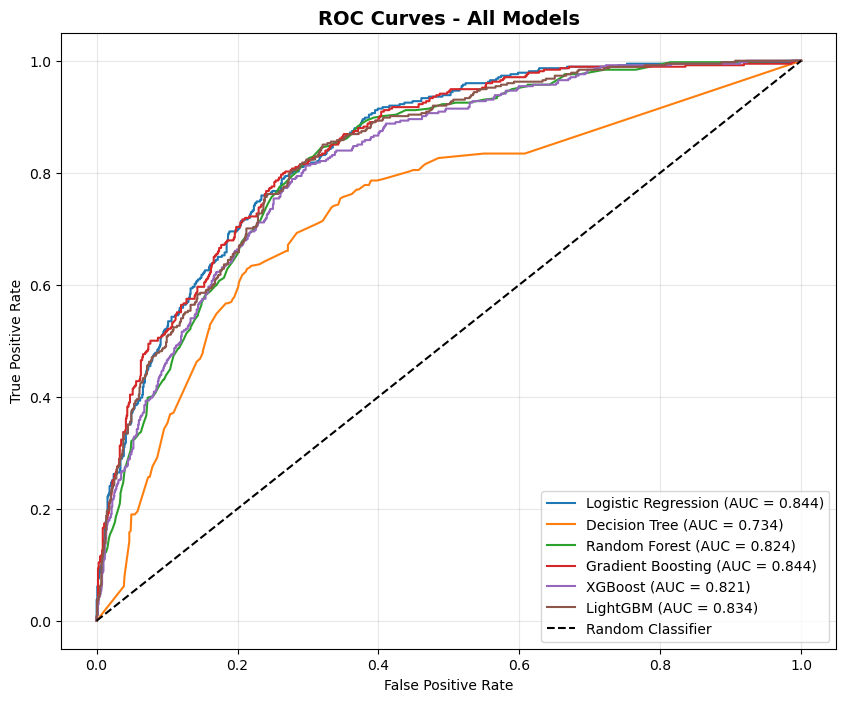

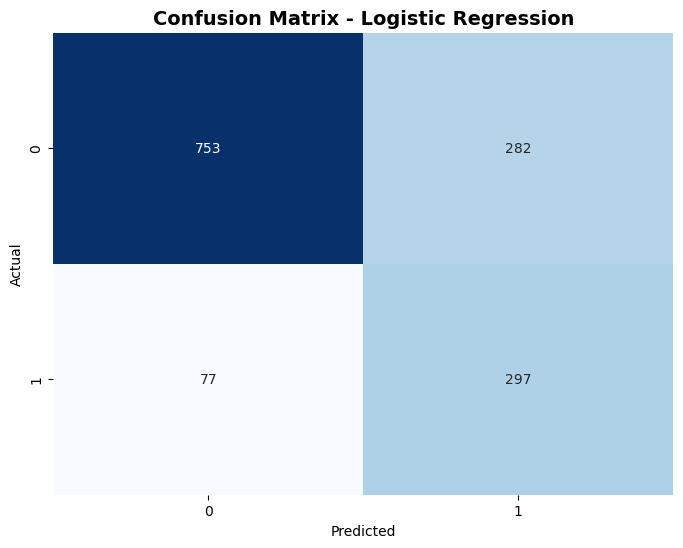

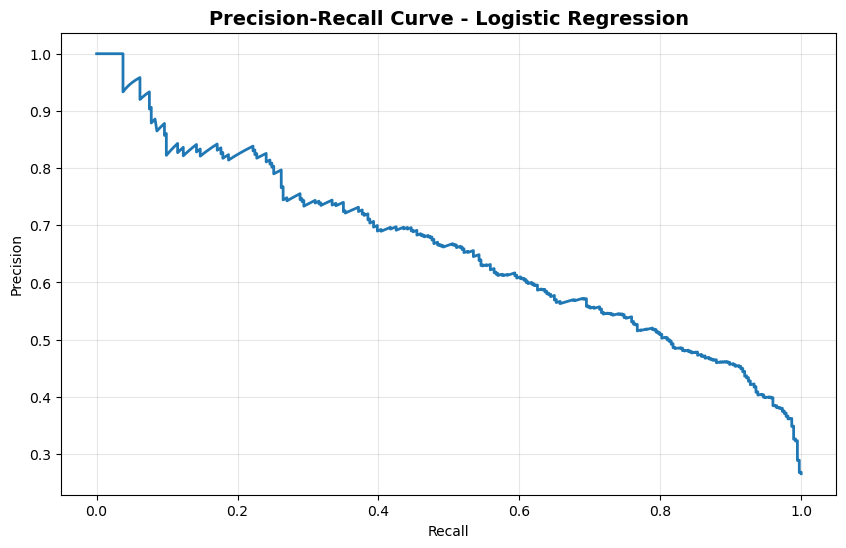

In [7]:
# 6. VISUALIZATIONS

print("\nCREATING VISUALIZATIONS")
print("="*80)

# 1. Model Comparison Bar Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    comparison_df[metric].plot(kind='barh', ax=ax, color='skyblue')
    ax.set_title(metric, fontweight='bold')
    ax.set_xlabel('Score')
    ax.set_xlim([0, 1])
    
    # Add value labels
    for i, v in enumerate(comparison_df[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center')

# Remove empty subplot
axes[1, 2].remove()

plt.tight_layout()
plt.show()

# 2. ROC Curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_pred_proba = results[name]['Probabilities']
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = results[name]['ROC-AUC']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 3. Confusion Matrix for Best Model
best_model = models[best_model_name]
y_pred_best = results[best_model_name]['Predictions']
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 4. Precision-Recall Curve for Best Model
y_pred_proba_best = results[best_model_name]['Probabilities']
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 6))
plt.plot(recall_vals, precision_vals, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()


In [8]:
# 7. DETAILED CLASSIFICATION REPORT

print("\nDETAILED CLASSIFICATION REPORT - BEST MODEL")
print("="*80)
print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))



DETAILED CLASSIFICATION REPORT - BEST MODEL
              precision    recall  f1-score   support

    No Churn       0.91      0.73      0.81      1035
       Churn       0.51      0.79      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



In [12]:
# 8. SAVE BEST MODEL

print("\nSAVING BEST MODEL")
print("="*80)

# Save model
os.makedirs('../model', exist_ok=True)

with open('../model/best_model(notebook).pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"Saved: best_model(notebook).pkl ({best_model_name})")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'accuracy': float(comparison_df.loc[best_model_name, 'Accuracy']),
    'precision': float(comparison_df.loc[best_model_name, 'Precision']),
    'recall': float(comparison_df.loc[best_model_name, 'Recall']),
    'f1_score': float(comparison_df.loc[best_model_name, 'F1-Score']),
    'roc_auc': float(comparison_df.loc[best_model_name, 'ROC-AUC'])
}

with open('../model/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print("Saved: model_metadata.pkl")

# Save comparison results
comparison_df.to_csv('../data/model_comparison.csv')
print("Saved: model_comparison.csv")



SAVING BEST MODEL
Saved: best_model(notebook).pkl (Logistic Regression)
Saved: model_metadata.pkl
Saved: model_comparison.csv


In [10]:
# 9. SUMMARY

print("MODELING SUMMARY")
print("="*80)

summary = {
    'Models Trained': len(models),
    'Best Model': best_model_name,
    'Best ROC-AUC': f"{comparison_df.loc[best_model_name, 'ROC-AUC']:.4f}",
    'Precision': f"{comparison_df.loc[best_model_name, 'Precision']:.4f}",
    'Recall': f"{comparison_df.loc[best_model_name, 'Recall']:.4f}"
}

for key, value in summary.items():
    print(f"{key:.<25} {value}")

print("\nModeling complete! Model saved and ready for deployment.")
print("="*80)

MODELING SUMMARY
Models Trained........... 6
Best Model............... Logistic Regression
Best ROC-AUC............. 0.8441
Precision................ 0.5130
Recall................... 0.7941

Modeling complete! Model saved and ready for deployment.
